In [62]:
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import random
import keras 
import tensorflow as tf
from keras import layers
import PIL
import cv2
import os
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import add, ReLU,Input,Layer,Conv2D , Dropout, multiply,MaxPool2D, LeakyReLU,Concatenate,UpSampling2D,Conv2DTranspose,BatchNormalization,MaxPooling2D
from keras.models import Model, load_model
# import Path
from PIL import Image
from IPython.core.display import Path
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [63]:
img_dir='/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/images'
mask_dir='/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/masks'

In [64]:
def image_mask_images (path_image,path_mask): 
    imgs = list()
    masks = list()
    files_img = Path(path_image).glob('*')
    files_mask = Path(path_mask).glob('*')
    i=0
    for img,msk in zip(files_img,files_mask):
        if i>500:
            break
        else:
            i+=1
            im = Image.open(img)
            mask=Image.open(msk)
            #resize
            im = im.resize(size=(256,256))
            mask = mask.resize(size=(256,256))
            #norm
            # mask/=255
            im = np.array(im)
            mask=np.array(mask)
            mask=mask/255.
            im=im/255.
            if len(im.shape)==3&len(mask.shape)==3:
              if im.shape[2]==3&mask.shape[2]==3:
                imgs.append(im)
                masks.append(mask)
    return np.array(imgs),np.array(masks)
    # return np.array(train)
    

In [65]:
imgs,masks=image_mask_images(img_dir,mask_dir)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split( imgs, masks, test_size=0.100, random_state=42)

In [67]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    

    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    return act2

def encoder(entered_input, filters=64):

    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):

    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    print(Upsample)
    Connect_Skip = Concatenate()([Upsample, skip])
    print(Connect_Skip)
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [68]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 512), dtype=tf.float32, name=None), name='conv2d_transpose_4/BiasAdd:0', description="created by layer 'conv2d_transpose_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1024), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concatenate_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='conv2d_transpose_5/BiasAdd:0', description="created by layer 'conv2d_transpose_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 512), dtype=tf.float32, name=None), name='concatenate_5/concat:0', description="created by layer 'concatenate_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 128), dtype=tf.float32, name=None), name='conv2d_transpose_6/BiasAdd:0', description="created by layer 'conv2d_transpose_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 256), dtype=tf.float32, name=None), name='concatenate_6/concat:

In [69]:
model.compile(optimizer='adam',loss='binary_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint("persons_U-Net.h5", save_best_only=True)
]

In [75]:
epochs = 100
model.fit(X_train,y_train, epochs=epochs, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 11s 739ms/step - loss: 0.1481
Epoch 2/100
15/15 [==============================] - 11s 739ms/step - loss: 0.1130
Epoch 3/100
15/15 [==============================] - 11s 738ms/step - loss: 0.1305
Epoch 4/100
15/15 [==============================] - 11s 738ms/step - loss: 0.1088
Epoch 5/100
15/15 [==============================] - 11s 737ms/step - loss: 0.1124
Epoch 6/100
15/15 [==============================] - 11s 739ms/step - loss: 0.0970
Epoch 7/100
15/15 [==============================] - 11s 738ms/step - loss: 0.0967
Epoch 8/100
15/15 [==============================] - 11s 738ms/step - loss: 0.1304
Epoch 9/100
15/15 [==============================] - 11s 738ms/step - loss: 0.1002
Epoch 10/100
15/15 [==============================] - 11s 739ms/step - loss: 0.0862
Epoch 11/100
15/15 [==============================] - 11s 739ms/step - loss: 0.1528
Epoch 12/100
15/15 [==============================] - 11s 738ms/step - loss: 0.1206
E

In [76]:
pred_masks = model.predict(X_test)

In [77]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 179ms/step - loss: 0.3236


0.3236466944217682

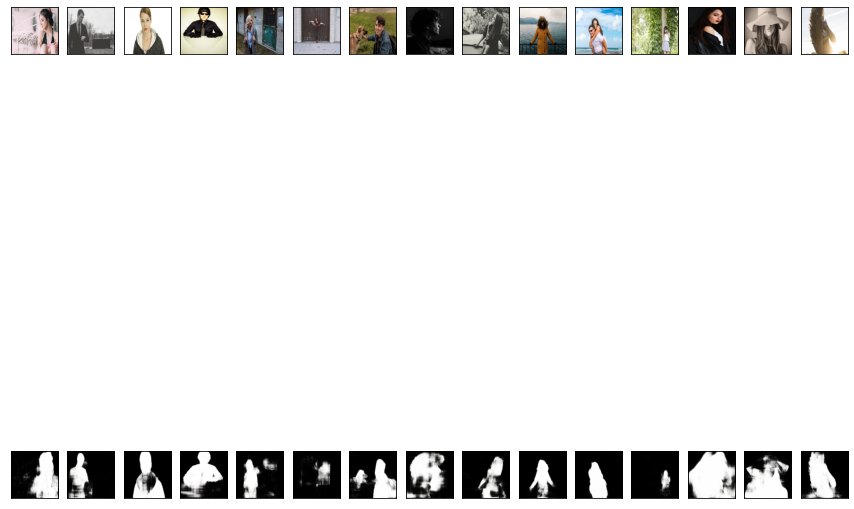

In [78]:
n=15
plt.figure(figsize=(15,15))
for i in range(1,16):
    image, mask,pred_mask = X_test[i],y_test[i],pred_masks[i]
    ax = plt.subplot(2, n, i)
    plt.imshow(image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#     ax = plt.subplot(3, n, i + n)
#     plt.imshow(mask)
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n)
    plt.imshow(pred_mask)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()